## Summary

---

## Imports

In [153]:
from pathlib import Path

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import pymc3 as pm
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option("max_columns", 1000)

## Parameters

In [3]:
NOTEBOOK_NAME = "bayesian-linear-regression"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_NAME

'bayesian-linear-regression'

## Load data

In [105]:
input_df = pq.read_table("01_prepare_combined_dataset/combined.parquet").to_pandas()

In [106]:
# input_df = pq.read_table("data-challenge/data_final.parquet").to_pandas()

In [ ]:
## Filter data

In [119]:
input_df["y"] = input_df[["acq2", "acq3", "acq4", "acq5"]].mean(axis=1) - input_df["acq"]

In [120]:
input_df = input_df[input_df["y"].notnull()]
input_df = input_df[
    (input_df[["acq", "acq2", "acq3", "acq4", "acq5"]] <= 6).all(axis=1)
]

In [121]:
assert len(input_df) == 143, len(input_df)

## Explore input data

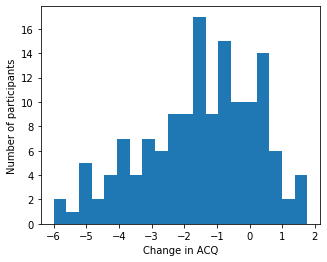

In [283]:
fg, ax = plt.subplots(figsize=(5, 4))
ax.hist(input_df["y"], bins=20)
ax.set_xlabel("Change in ACQ")
ax.set_ylabel("Number of participants")
None

In [284]:
input_df.columns

Index(['id', 'date_x', 'acq', 'date2', 'acq2', 'date3', 'acq3', 'date4',
       'acq4', 'date5', 'acq5', 'co-copd', 'co-heartfailure', 'co-diabetes',
       'co-yellowfever', 'co-asthma', 'co-pulmonaryembolism', 'co-bronchitis',
       'co-arthritis', 'co-pneumonia', 'medhistory_table', 'assess_x',
       'smoking', 'polyps', 'vaccine', 'arthritis', 'CVD', 'Prev-biologic',
       'allergy', 'weight', 'height', 'age', 'race', 'ethnicity', 'gender',
       'work', 'retire', 'disab', 'demographics_table', 'assess_y',
       'birthyear', 'sex', 'date_y', 'clinic', 'infconsent', '18+', 'eos300',
       'eos150', 'sputum', 'acq-screen', 'result', 'y'],
      dtype='object')

In [ ]:
input_df[c]

## Fit model

In [207]:
def encode_categorical(df, column):
    categories = {c: i for i, c in enumerate(set(df[column]))}
    df[column] = df[column].map(categories)

In [208]:
columns_to_drop = [
    'date_x', 'acq', 'date2', 'acq2', 'date3', 'acq3', 
    'date4', 'acq4', 'date5', 'acq5', "assess_y", "date_y"
]
data_df = input_df.drop(pd.Index(columns_to_drop), axis=1)

columns_to_keep = [
    "y"]


categorical_feature=[
    "medhistory_table",
    "race",
    "ethnicity",
    "work",
    "disab",
    "demographics_tabl",
    "clinic",
    "infconsent",
    "18+",
    "result",
]
categorical_feature = [c for c in categorical_feature if c in data_df]
for column in categorical_feature:
    encode_categorical(data_df, column)
    
    


In [209]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [210]:
for train_index, test_index in kf.split(df_train):
    train_df = data_df.iloc[train_index]
    test_df = data_df.iloc[test_index]
    X_train = train_df.drop("y", axis=1)
    y_train = train_df["y"]
    X_test = test_df.drop("y", axis=1)
    y_test = test_df["y"]
    
    break

In [211]:
train_df.dtypes

id                        int64
co-copd                 float64
co-heartfailure         float64
co-diabetes             float64
co-yellowfever          float64
co-asthma               float64
co-pulmonaryembolism    float64
co-bronchitis           float64
co-arthritis            float64
co-pneumonia            float64
medhistory_table          int64
assess_x                float64
smoking                 float64
polyps                  float64
vaccine                 float64
arthritis               float64
CVD                     float64
Prev-biologic           float64
allergy                 float64
weight                  float64
height                  float64
age                     float64
race                      int64
ethnicity                 int64
gender                  float64
work                      int64
retire                  float64
disab                     int64
demographics_table        int64
birthyear               float64
sex                     float64
clinic  

In [212]:
train_df.head()

,id,co-copd,co-heartfailure,co-diabetes,co-yellowfever,co-asthma,co-pulmonaryembolism,co-bronchitis,co-arthritis,co-pneumonia,medhistory_table,assess_x,smoking,polyps,vaccine,arthritis,CVD,Prev-biologic,allergy,weight,height,age,race,ethnicity,gender,work,retire,disab,demographics_table,birthyear,sex,clinic,infconsent,18+,eos300,eos150,sputum,acq-screen,result,y
0,122,NaN,0.134831,0.088137,NaN,0.791711,NaN,NaN,NaN,0.154149,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,3,5,2.0,0,1.0,0,0,NaN,NaN,0,0,0,1.0,NaN,NaN,4.833333,1,-1.362167
1,129,1.0,0.975158,0.440870,NaN,0.166631,NaN,NaN,NaN,0.067263,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,3,5,1.0,1,NaN,1,0,NaN,NaN,0,0,0,1.0,NaN,NaN,1.333333,0,-1.410933
2,120,1.0,0.727836,0.787530,NaN,0.948943,NaN,NaN,NaN,0.845027,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,3,5,0.0,0,1.0,1,0,NaN,NaN,0,0,0,1.0,NaN,NaN,4.666667,1,0.681100
3,127,0.0,0.891873,0.963744,NaN,0.993591,NaN,NaN,NaN,0.256935,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,3,6,1.0,1,NaN,1,0,NaN,NaN,0,0,0,1.0,NaN,NaN,4.166667,1,-4.342200
4,123,NaN,0.656758,0.851192,NaN,NaN,NaN,NaN,NaN,0.383282,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,3,1,3.0,0,1.0,1,0,NaN,NaN,0,0,0,1.0,NaN,NaN,3.166667,1,-0.948000


In [239]:
lgb_train = lgb.Dataset(
    X_train, y_train, categorical_feature=categorical_feature, free_raw_data=False)
lgb_test = lgb.Dataset(
    X_test, y_test, reference=lgb_train, categorical_feature=categorical_feature, free_raw_data=False)

In [249]:
# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
grid_params = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

In [241]:
mdl = lgb.LGBMRegressor(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [277]:
def iter_grid_params(grid_params):
    if not grid_params:
        return [{}]
    grid_params = grid_params.copy()
    key, values = grid_params.popitem()
    result = []
    for child_dict in iter_grid_params(grid_params):
        for value in values:
            result.append({**child_dict, key: value})
    return result

In [281]:
for params_extra in iter_grid_params(grid_params):
    gbm = lgb.train(
        {**params, **params_extra},
        lgb_train,
        100000,
        valid_sets=[lgb_train, lgb_test],
        early_stopping_rounds=50,
        verbose_eval=0,
    )

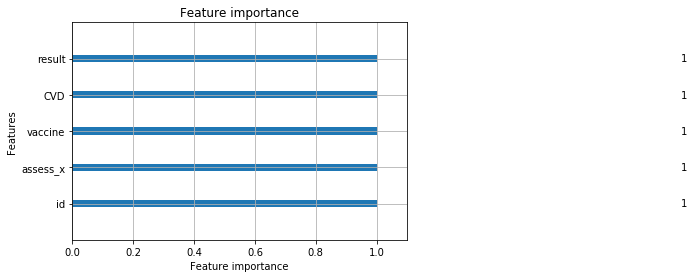

In [282]:
lgb.plot_importance(gbm)

In [237]:
gbm.best_score

defaultdict(collections.OrderedDict, {})

In [231]:
gridParams = {
    'learning_rate': [ 0.1],
    'num_leaves': [63],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary']
}

mdl = lgb.LGBMClassifier(
    task = params['task'],
    metric = params['metric'],
    metric_freq = params['metric_freq'],
    is_training_metric = params['is_training_metric'],
    max_bin = params['max_bin'],
    tree_learner = params['tree_learner'],
    feature_fraction = params['feature_fraction'],
    bagging_fraction = params['bagging_fraction'],
    bagging_freq = params['bagging_freq'],
    min_data_in_leaf = params['min_data_in_leaf'],
    min_sum_hessian_in_leaf = params['min_sum_hessian_in_leaf'],
    is_enable_sparse = params['is_enable_sparse'],
    use_two_round_loading = params['use_two_round_loading'],
    is_save_binary_file = params['is_save_binary_file'],
    n_jobs = -1
)

KeyError: 'task'